# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).    

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. 

Бюджет на разработку скважин в регионе — 10 млрд рублей.    

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

Описание данных:
  -  id — уникальный идентификатор скважины;
  -  f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
  -  product — объём запасов в скважине (тыс. баррелей).

In [17]:
#pip install ydata-profiling

# Импорт библиотек

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка и подготовка данных

In [19]:
data_1 = pd.read_csv("C://Users/rdl_b/OneDrive/Рабочий стол/python/Yandex Practicum/Загрузка проектов/Проект 9/geo_data_0.csv")
data_2 = pd.read_csv("C://Users/rdl_b/OneDrive/Рабочий стол/python/Yandex Practicum/Загрузка проектов/Проект 9/geo_data_1.csv")
data_3 = pd.read_csv("C://Users/rdl_b/OneDrive/Рабочий стол/python/Yandex Practicum/Загрузка проектов/Проект 9/geo_data_2.csv")

**Посмотрим на данные**

In [20]:
data_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [21]:
data_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [22]:
data_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [23]:
def info(df):
    df.info()
    print('\nКоличество дубликатов:',df.duplicated().sum(),'\n')
    print('Количество пропусков:\n',df.isna().sum())

In [24]:
info(data_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество дубликатов: 0 

Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [25]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [26]:
info(data_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество дубликатов: 0 

Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [27]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [28]:
info(data_3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество дубликатов: 0 

Количество пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [29]:
data_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Построим матрицы корреляции:

In [30]:
def corr_matrix(data):
    numeric_cols = data.select_dtypes(include=['number']).columns
    correlation_matrix = data[numeric_cols].corr()

    plt.figure(figsize=(8, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()


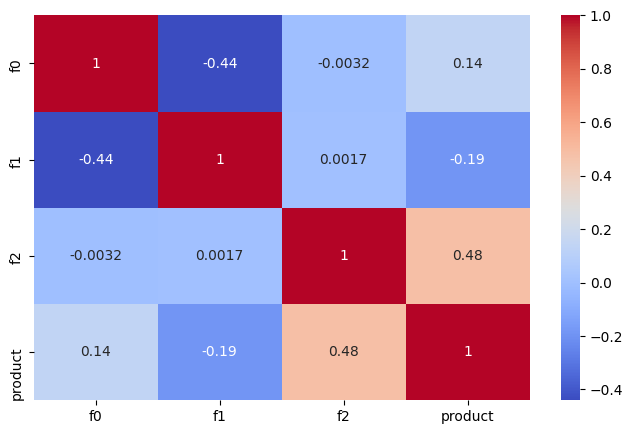

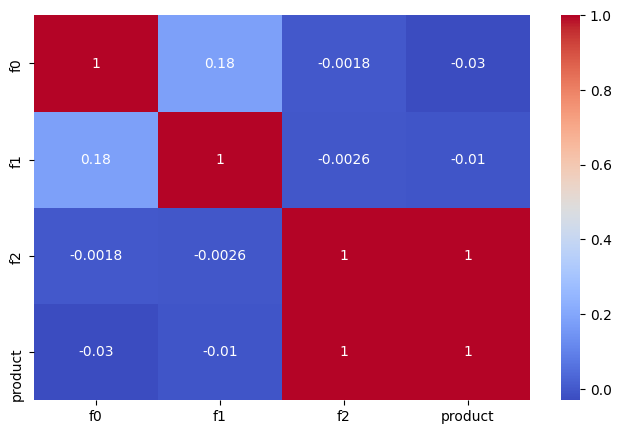

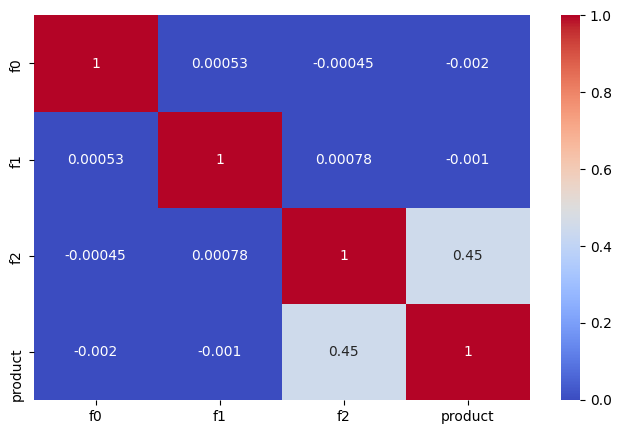

In [31]:
corr_matrix(data_1)
corr_matrix(data_2)
corr_matrix(data_3)

1. Данные не нуждаются в предобработке. Названия стобцов в нужном регистре, пропусков и явных дубликатов нет, данные указаны в правильном типе. 
2. В втором фрейме очень сильно коррелирует целевой признак и f2.
3. Переходим к обучению модели.

**Вывод:**

- Пропуски - отсутствуют
- Типы столбцов - соответсвуют данным
- Названия столбцов - ок
- Дубликаты - отсутствуют
- Коррелирующие признаки - f2 и целевой признак сильно коррелируют, но согласно заданию признак f2 оставим/.

In [32]:
#from ydata_profiling import ProfileReport

In [33]:
#profile = ProfileReport(data_1, title="Profiling Report")

In [34]:
#profile

## Обучение и проверка модели

Удалим признак id и f2 из второго фрейма

In [35]:
data_1.drop(["id"], axis=1, inplace=True)
data_2.drop(["id"], axis=1, inplace=True)
data_3.drop(["id"], axis=1, inplace=True)

In [36]:
data_2.head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


### Разделение на выборки

In [37]:
def split_df(data_split):
    features = data_split.drop("product",axis=1)
    target = data_split["product"]
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                  test_size=0.25, random_state=42)
    
    return features_train, features_valid, target_train, target_valid

In [38]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_df(data_1)

In [39]:
print(f'Размер исходного датафрейма: {data_1.shape}')
print(f'Размер признака обучающей выборке: {features_train_1.shape}')
print(f'Размер целевого признака обучающей выборке: {target_train_1.shape[0]}')
print(f'Размер признака валидационной выборки: {features_valid_1.shape}')
print(f'Размер целевого признака валидационной выборки: {target_valid_1.shape[0]}')

Размер исходного датафрейма: (100000, 4)
Размер признака обучающей выборке: (75000, 3)
Размер целевого признака обучающей выборке: 75000
Размер признака валидационной выборки: (25000, 3)
Размер целевого признака валидационной выборки: 25000


In [40]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_df(data_2)

In [41]:
print(f'Размер исходного датафрейма: {data_2.shape}')
print(f'Размер признака обучающей выборке: {features_train_2.shape}')
print(f'Размер целевого признака обучающей выборке: {target_train_2.shape[0]}')
print(f'Размер признака валидационной выборки: {features_valid_2.shape}')
print(f'Размер целевого признака валидационной выборки: {target_valid_2.shape[0]}')

Размер исходного датафрейма: (100000, 4)
Размер признака обучающей выборке: (75000, 3)
Размер целевого признака обучающей выборке: 75000
Размер признака валидационной выборки: (25000, 3)
Размер целевого признака валидационной выборки: 25000


In [42]:
features_train_3, features_valid_3, target_train_3, target_valid_3 = split_df(data_3)

In [43]:
print(f'Размер исходного датафрейма: {data_3.shape}')
print(f'Размер признака обучающей выборке: {features_train_3.shape}')
print(f'Размер целевого признака обучающей выборке: {target_train_3.shape[0]}')
print(f'Размер признака валидационной выборки: {features_valid_3.shape}')
print(f'Размер целевого признака валидационной выборки: {target_valid_3.shape[0]}')

Размер исходного датафрейма: (100000, 4)
Размер признака обучающей выборке: (75000, 3)
Размер целевого признака обучающей выборке: 75000
Размер признака валидационной выборки: (25000, 3)
Размер целевого признака валидационной выборки: 25000


### Обучиние модели и предсказание на валидационной выборке.

In [44]:
def model_predict(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train,target_train)
    predictions_valid = pd.Series(model.predict(features_valid))
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5
    mean = predictions_valid.mean()
    
    return predictions_valid, rmse, mean

# Регион 1

In [45]:
predictions_valid_1, rmse_1, mean_1 = model_predict(features_train_1, 
                                                       features_valid_1, 
                                                       target_train_1, 
                                                       target_valid_1
                                                      )

In [46]:
print("RMSE модели:",rmse_1)
print("Средний запас сырья в регионе:",mean_1)

RMSE модели: 37.75660035026169
Средний запас сырья в регионе: 92.39879990657768


# Регион 2

In [47]:
predictions_valid_2, rmse_2, mean_2 = model_predict(features_train_2, 
                                                       features_valid_2, 
                                                       target_train_2, 
                                                       target_valid_2
                                                      )

In [48]:
print("RMSE модели:",rmse_2)
print("Средний запас сырья в регионе:",mean_2)

RMSE модели: 0.8902801001028854
Средний запас сырья в регионе: 68.71287803913762


# Регион 3

In [49]:

predictions_valid_3, rmse_3, mean_3 = model_predict(features_train_3, 
                                                       features_valid_3, 
                                                       target_train_3, 
                                                       target_valid_3
                                                      )

In [50]:
print("RMSE модели:",rmse_3)
print("Средний запас сырья в регионе:",mean_3)

RMSE модели: 40.145872311342174
Средний запас сырья в регионе: 94.77102387765939


**Вывод:**

Исходя из прогноза модели, то средний запас у 1 и 3 региона намного больше, чем у второго. Оданко, у данных регионов RMSE модели тоже значительно выше, чем у второго региона. Это говорит о том, что во втором регионе наибольшая точность предсказания сырья

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. 

Бюджет на разработку скважин в регионе — 10 млрд рублей.    

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.   

Исходя из условия задачи, зададим константы

In [51]:
explore = 500
mining = 200 
bank = 10000000000
revenue_per_barrel = 450000
loss_probability = 0.025
bootstrap_number = 1000

### Расчет достаточного объема сырья

In [52]:
print("Объем сырья для безубыточной разработки 1 скважины:", bank / mining / revenue_per_barrel)

Объем сырья для безубыточной разработки 1 скважины: 111.11111111111111


In [53]:
print("Средний запас сырья в регионе 1:",mean_1)
print("Средний запас сырья в регионе 2:",mean_2)
print("Средний запас сырья в регионе 3:",mean_3)

Средний запас сырья в регионе 1: 92.39879990657768
Средний запас сырья в регионе 2: 68.71287803913762
Средний запас сырья в регионе 3: 94.77102387765939


Минимальное среднее количество продукта в месторождениях региона, достаточное для разработки составляет 111.11 тыс. баррелей

**Вывод:**
    Средних запасов нефти во всех регионах недостаточно для окупаемости добычи. Однако исходить из средних в данном случае не целесообразно, поэтому посчитаем прибыль, исходя из 200 наиболее перспектинвых скважин в каждом регионе

## Расчёт прибыли и рисков 

In [54]:
def dohod(target_valid,predictions_valid,count):
    top_mining = predictions_valid.sort_values(ascending=False)
    target_choice = target_valid[top_mining.index][:count]
    income = (target_choice.sum() * revenue_per_barrel) - bank
    return income

In [55]:
def income_risks (target_valid, predictions_valid,  bootstrap_samples, explore):
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(bootstrap_samples):
        target_subsample = target_valid.reset_index(drop=True).sample(explore, replace=True, random_state=state)
        probs_subsample = predictions_valid[target_subsample.index]
        rev = dohod(target_subsample, probs_subsample,mining)
        values.append(rev)

    values = pd.Series(values)

    lower = values.quantile(0.025) 
    upper = values.quantile(0.975) 
    mean = values.mean()
    risks = len(values[values < 0])/len(values)*100
    
    print("Средняя выручка:", mean)
    print("95%-квантиль по выручке:", upper)
    print("5%-квантиль по выручке:", lower)
    print("Вероятность убытков:",risks,"%")

In [56]:
print('Для первого региона при случайном выборе 500 скважин получаются следующие показатели:')
income_risks(target_valid_1, predictions_valid_1,  bootstrap_number, explore)

Для первого региона при случайном выборе 500 скважин получаются следующие показатели:
Средняя выручка: 435933772.1386621
95%-квантиль по выручке: 966504180.707376
5%-квантиль по выручке: -116231612.77720818
Вероятность убытков: 6.1 %


In [57]:
print('Для второго региона при случайном выборе 500 скважин получаются следующие показатели:')
income_risks(target_valid_2, predictions_valid_2,  bootstrap_number, explore)

Для второго региона при случайном выборе 500 скважин получаются следующие показатели:
Средняя выручка: 489661254.41175246
95%-квантиль по выручке: 905762650.4248402
5%-квантиль по выручке: 55116177.27361494
Вероятность убытков: 1.0999999999999999 %


In [58]:
print('Для третьего региона при случайном выборе 500 скважин получаются следующие показатели:')
income_risks(target_valid_3, predictions_valid_3,  bootstrap_number, explore)

Для третьего региона при случайном выборе 500 скважин получаются следующие показатели:
Средняя выручка: 403687927.86213845
95%-квантиль по выручке: 952887416.7078604
5%-квантиль по выручке: -153116984.7619049
Вероятность убытков: 7.1 %


Наиболее лучшим регионом по выручке является - второй. При этом только в данном регионе вероятность убытков равна 1.1% и лежит в допустимом значении (Максимальное - 2.5%). 

# Вывод

1. Первый регион:
- Средняя выручка: 435933772
- Вероятность убытков: 6.1 %

2. Второй регион:
- Средняя выручка: 489661254
- Вероятность убытков: 1.1

2. Третий регион:
- Средняя выручка: 403687927
- Вероятность убытков: 7.1 %

Исходя из этого самый лучший регион по выручке и вероятности убытков - второй.